notebook version 1.10

- Section 1: Install Notes
- Section 2: Input Data
- Section 3: User-specified parameters/flags
- Section 4: Function Definitions
- Section 5: pPXF Best Fit Executions

User should update directories in Sections 1 & 2, define  parameters as required in Section 3. <br>
User can then execute Sections 4 and 5 to provide pPXF fits for all galaxies listed in input.<br>
NB. Output data will be stored in a folder generated in the location of this notebook.

## 1. pPXF INSTALL NOTES

The pPXF iPthon module can be downloaded from:

http://www-astro.physics.ox.ac.uk/~mxc/software/ppxf_python_2016-08-09.zip

- Extract the pPXF folder to some directory (the expected convention is to put it the .../site-packages/ directory wherever all iPython or Anaconda software is located)
- Include the following code to tell iPython to search for packages in the pPXF directory:

In [4]:
import sys
#sys.path.append('C:\\users\\alana\\anaconda2\\lib\\site-packages\\ppxf')
sys.path.append('C:\\Users\\Brendan\\ppxf')
sys.path.append('C:\Users\Brendan\s2plot-python-master')
##### THIS DIRECTORY WILL NEED TO BE CHANGED DEPENDING ON YOUR SYSTEM #####

In [5]:
sys.path

['',
 'C:\\Users\\Brendan\\Anaconda2\\python27.zip',
 'C:\\Users\\Brendan\\Anaconda2\\DLLs',
 'C:\\Users\\Brendan\\Anaconda2\\lib',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\plat-win',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\lib-tk',
 'C:\\Users\\Brendan\\Anaconda2',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\Sphinx-1.4.1-py2.7.egg',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\win32',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\setuptools-23.0.0-py2.7.egg',
 'C:\\Users\\Brendan\\Anaconda2\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Brendan\\.ipython',
 'C:\\Users\\Brendan\\ppxf',
 'C:\\Users\\Brendan\\ppxf',
 'C:\\Users\\Brendan\\s2plot-python-master']

- Include the following code to call the pPXF package:

In [9]:
from __future__ import print_function
import astropy.io.fits as fits
import os
from datetime import datetime
from scipy import ndimage
import numpy as np
from time import clock,strftime
import glob
from ppxf import ppxf
import ppxf_util as util
import matplotlib.pylab as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from s2plot import s2plot
%matplotlib inline

ImportError: No module named s2plot

- If this throws an exception, the above directory is incorrect. If not, pPXF is ready to go!

## 2. Define Data

In [3]:
# Define the path of the fits files which contain the data we want to work with:

### Abell 1689 ###
#All='ppxf\spectra\A1689all.fits'                         # All parameters for each observed galaxy (eg z, sigma)
#Obs='ppxf\spectra\crA1689_1D.fits'                       # Observed frame spectral data
#Rest='ppxf\spectra\sA1689_1D_restframe.fits'             # Rest frame spectral data
#Instres='ppxf\spectra\Ainstres_mdf.fits'                  # Instrumental resolution data

### RXJ0056 ###
All='ppxf\spectra\RXJ0056p2p2622all.fits'                # All parameters for each observed galaxy (eg z, sigma)
Obs='ppxf\spectra\crRXJ0056p2p2622_1D.fits'              # Observed frame spectral data
Rest='ppxf\spectra\sRXJ0056p2p2622_1D_restframe.fits'    # Rest frame spectral data
Instres='ppxf\spectra\RXJinstres_mdf.fits'               # Instrumental resolution data

### MS0451 ###
#All='ppxf\spectra\MS0451p6m0305all.fits'                 # All parameters for each observed galaxy (eg z, sigma)
#Obs='ppxf\spectra\crMS0451p6m0305_1D.fits'             # Observed frame spectral data
#Rest='ppxf\spectra\sMS0451p6m0305_1D_restframe.fits'     # Rest frame spectral data
#Instres='ppxf\spectra\MSinstres_mdf.fits'       # Instrumental resolution data

# Open data files
allhdu=fits.open(All)                 
crhdu=fits.open(Obs)                
shdu=fits.open(Rest)                  
instreshdu=fits.open(Instres)  

with fits.open(All) as allhdu:
    # Links galaxy ID to ExtVer:
    ID_extver_dict = {allhdu[1].data[i]['NUMBERI']:allhdu[1].data[i]['SCI_EXT']  for i in range(allhdu[1].header['NAXIS2'])}
    # Links galaxy ID to Redshift:
    ID_Redshift_dict = {allhdu[1].data[i]['NUMBERI']: allhdu[1].data[i]['Z_IN'] for i in range(allhdu[1].header['NAXIS2'])}

## 3. User-specified Inputs:

In [21]:
Cluster_Name = 'RXJ0056p2p2622'
#Cluster_Name = 'Abell_1689'
#Cluster_Name = 'MS0451p6m0305'    
IDlist =[-1]                #Galaxy ID(s) to use in ppxf. Use [-1] to run all
exclude = []                     # Galaxy ID(s) to be excluded from the set ONLY IF IDlist = [-1] (run all)
observed = False                 # Observed frame = True, Rest frame = False
mask_skyline = True              # True = mask the 5577A atmospheric oxygen emission line
mask_wavelength_width=4          # Number of Angstrom either side of 5577 to mask 
mask_lines = []

model_dir = 'ppxf/miles_models/Mun1.30' # directory to spectral library models, with most general filename prefix

Regularisation=True              # False = use zero regularisation, for best spectral fit or fast-check
User_regul=[-1,-1]               # regul_err & noise_scale vals respectively, or use [-1,-1] for optimisation.
                                 # These values are output to primary header. NOTE: Regularization = 1/regul_err
num_err=10                       # Number of test regul_err values. Higher value = finer sampling, but slower.

Save_plots=True                  # If True, saves output bestfit & Age/Metallicity plots (.jpg) to output directory

lambda_bounds=[3750,5500]            # The lower and upper bounds on wavelength (Angstrom) to be included in the fit.
                                 # Use -1 for no bound, eg: [-1,-1] = unbounded, [-1,6000] = upper bound 6000A.

## 4. Define Functions

In [22]:
#!/usr/bin/env python
##############################################################################
#
# This PPXF_POPULATION_EXAMPLE routine shows how to study stellar population with
# the procedure PPXF, which implements the Penalized Pixel-Fitting (pPXF) method by
# Cappellari M., & Emsellem E., 2004, PASP, 116, 138.
#
# MODIFICATION HISTORY:
#   V1.0.0: Adapted from PPXF_KINEMATICS_EXAMPLE.
#       Michele Cappellari, Oxford, 12 October 2011
#   V1.1.0: Made a separate routine for the construction of the templates
#       spectral library. MC, Vicenza, 11 October 2012
#   V1.1.1: Includes regul_error definition. MC, Oxford, 15 November 2012
#   V2.0.0: Translated from IDL into Python. MC, Oxford, 6 December 2013
#   V2.0.1: Fit SDSS rather than SAURON spectrum. MC, Oxford, 11 December 2013
#   V2.0.2: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
#   V2.0.3: Explicitly sort template files as glob() output may not be sorted.
#       Thanks to Marina Trevisan for reporting problems under Linux.
#       MC, Sydney, 4 February 2015
#   V2.0.4: Included origin='upper' in imshow(). Thanks to Richard McDermid
#       for reporting a different default value with older Matplotlib versions.
#       MC, Oxford, 17 February 2015
#   V2.1.0: Illustrates how to compute mass-weighted quantities from the fit.
#       After feedback from Tatiana Moura. MC, Oxford, 25 March 2015
#   V2.1.1: Use redshift in determine_goodpixels. MC, Oxford, 3 April 2015
#   V2.1.2: Support both Pyfits and Astropy to read FITS files.
#       MC, Oxford, 22 October 2015
#
##############################################################################



def setup_spectral_library(velscale, FWHM_gal):

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis et al. (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    #
    # For this example I downloaded from the above website a set of
    # model spectra with default linear sampling of 0.9A/pix and default
    # spectral resolution of FWHM=2.51A. I selected a Salpeter IMF
    # (slope 1.30) and a range of population parameters:
    #
    #     [M/H] = [-1.71, -1.31, -0.71, -0.40, 0.00, 0.22]
    #     Age = np.linspace(np.log10(1), np.log10(17.7828), 26)
    #
    # This leads to a set of 276 model spectra with the file names like
    #
    #     Iun1.30Zm0.40T03.9811.fits
    #
    # IMPORTANT: the selected models form a rectangular grid in [M/H]
    # and Age: for each Age the spectra sample the same set of [M/H].
    #
    # We assume below that the model spectra have been placed in the
    # directory "miles_models" under the current directory.
    #
    vazdekis = glob.glob('%s'%model_dir+'*.fits')
    vazdekis.sort()
    FWHM_tem = 2.51 # Vazdekis+10 spectra have a resolution FWHM of 2.51A.

    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SDSS galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange_temp = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1']-1)])
    sspNew, logLam2, velscale = util.log_rebin(lamRange_temp, ssp, velscale=velscale)

    # Create a three dimensional array to store the
    # two dimensional grid of model spectra
    isochrone_list=glob.glob('%s'%model_dir+'Zm0.40'+'*.fits')
    ages_array=[]
    for iso in isochrone_list:
        ages_array.append(float(iso[-12:-5]))
    nAges = len(ages_array)
    nMetal = len(vazdekis)/nAges

    templates = np.empty((sspNew.size, nAges, nMetal))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    # These are the array where we want to store
    # the characteristics of each SSP model
    #
    logAge_grid = np.empty((nAges, nMetal))
    metal_grid = np.empty((nAges, nMetal))

    # These are the characteristics of the adopted rectangular grid of SSP models
    #
    logAge = np.linspace(np.log10(1), np.log10(17.7828), nAges)
    metal = [-1.71, -1.31, -0.71, -0.40, 0.00, 0.22]

    # Here we make sure the spectra are sorted in both [M/H]
    # and Age along the two axes of the rectangular grid of templates.
    # A simple alphabetical ordering of Vazdekis's naming convention
    # does not sort the files by [M/H], so we do it explicitly below
    #
    metal_str = ['m1.71', 'm1.31', 'm0.71', 'm0.40', 'p0.00', 'p0.22']
    for k, mh in enumerate(metal_str):
        files = [s for s in vazdekis if mh in s]
        for j, filename in enumerate(files):
            hdu = fits.open(filename)
            ssp = hdu[0].data
            ssp = ndimage.gaussian_filter1d(ssp,sigma)
            sspNew, logLam2, velscale = util.log_rebin(lamRange_temp, ssp, velscale=velscale)
            templates[:, j, k] = sspNew  # Templates are *not* normalized here
            logAge_grid[j, k] = logAge[j]
            metal_grid[j, k] = metal[k]

    return templates, lamRange_temp, logAge_grid, metal_grid, nAges, ages_array, nMetal, metal

#------------------------------------------------------------------------------

def ppxf_prep(ID):
   
    #instrument resolution
    instres = fits.open(Instres)
    Extver=ID_extver_dict[ID]
    
    #if observed frame, uses observed file
    if observed:
        hdu = fits.open(Obs)
        z = ID_Redshift_dict[ID] #redshift
        # for Sigma in Angstrom
        FWHM_gal= 2.355*instres[1].data['crsigma_science'][Extver-1]
        
    #if rest frame, use restframe file    
    else:
        hdu = fits.open(Rest)
        z = 0 #redshift
        # for Sigma in Angstrom
        FWHM_gal = (2.355*instres[1].data['crsigma_science'][Extver-1])/(1 + ID_Redshift_dict[ID])
    
    # spectral data
    gal_lin = hdu['SCI',Extver].data
    # header data
    h1 = hdu['SCI',Extver].header
    c = 299792.458 # speed of light in km/s
    lamRange1 = h1['CRVAL1'] + np.array([0., h1['CD1_1']*(h1['NAXIS1'] - 1)])
        
    return h1, hdu, Extver, lamRange1, z, FWHM_gal, c, gal_lin

#------------------------------------------------------------------------------

def optim_regul(ID, goodpixels):
    
    'Loops over a range of regul_err values for a given galaxy to determine the best value to use.'
    ######BEGIN PREP F'N
    h1, hdu, Extver, lamRange1, z, FWHM_gal, c, gal_lin = ppxf_prep(ID)
    #Log rebin wavelengths
    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    gal_med = np.median(galaxy)
    galaxy = galaxy/gal_med  # Normalize spectrum to avoid numerical issues
    
#########################  Determine Noise spectrum scaling factor  #########################
    
    # noise taken from noise spectrum in FITS
    noise =  hdu['rms',Extver].data
    noise = noise/gal_med
    t = clock()

    #Setup Spectral Library
    templates, lamRange_temp, logAge_grid, metal_grid, nAges, ages_array, nMetal, metal = \
        setup_spectral_library(velscale, FWHM_gal)

    dv = c*np.log(lamRange_temp[0]/lamRange1[0])  # km/s

    vel = c*np.log(1 + z)   # Initial estimate of the galaxy velocity in km/s
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    templates /= np.median(templates) # Normalizes templates by a scalar

#########################  Optimize Regularization  ################################

    # If regularization is optimised (Section 3):
    if User_regul==[-1,-1]:
        print('Optimising noise_scale & regul_err..')
        #Run ppxf once with no regularization, to determing the noise scaling factor (sqrt(chi^2))
        pp_free = ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodpixels, plot=False, moments=4, degree=-1,
                  vsyst=dv, clean=False, mdegree=15, regul=0.)
        #Rescale the noise spectrum accordingly
        noise_scale=pp_free.chi2
        noise = noise*np.sqrt(noise_scale)        
        
        #Create a log array of regul_err test values:
        regul_err_array  = 10**np.linspace(0,-5,num=num_err)
        #Test regul_err values to determine which regul_err yields the desired chi^2 value     
        count_err=1

        for err in regul_err_array:
            pp = ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodpixels, plot=False, moments=4, degree=-1,
                  vsyst=dv, clean=False, mdegree=15, regul=1./err)
            print('Desired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
            print('Current Delta Chi^2 using regul_err=%.4g: %.4g' % (err, (pp.chi2 - 1)*goodpixels.size))
            if ((pp.chi2 - 1)*goodpixels.size) <= np.sqrt(2*goodpixels.size):
                last_err_under=err    #The last 'good' regul_err value before chi^2 surpasses desired value
                last_chi_under=((pp.chi2 - 1)*goodpixels.size)
            else:
                over_err=err    #The 'bad' regul_err values for which chi^2 has gone too far
                over_chi=(pp.chi2 - 1)*goodpixels.size
                break
            if count_err == num_err:
                over_err=last_err_under
                over_chi=last_chi_under+1.
                break
            count_err +=1
        
        if count_err == 1:
            optimal_regul_err = 1.
        else:
            # Use the two test points straddling desired delta chi^2 to make a linear estimate of the ideal regul_err value
            chi_range = over_chi-last_chi_under
            print('chi range: ',chi_range)
            chi_frac=(np.sqrt(2*goodpixels.size)-last_chi_under)/chi_range 
            # Gives fraction of the step between last good chi^2 and first bad chi^2, to estimate the optimal regul_err value
            err_step = last_err_under-over_err
            optimal_regul_err=last_err_under-(err_step*chi_frac)
    
    # If only the regul_err value is specified, optimise scaling only.
    elif not User_regul[0]==-1 and User_regul[1]==-1:
        print('regul_err specified, optimising noise_scale..')
        pp_free = ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodpixels, plot=False, moments=4, degree=-1,
                  vsyst=dv, clean=False, mdegree=15, regul=0.)
        
        optimal_regul_err=User_regul[0]
        noise_scale=pp_free.chi2
    
    # If only the noise_scale value is specified, optimise regul_err only.
    elif User_regul[0]==-1 and not User_regul[1]==-1:
        print('noise_scale specified, optimising regul_err..')
        noise_scale=User_regul[1]
        noise = noise*np.sqrt(noise_scale)
        
        #Create a log array of regul_err test values:
        regul_err_array  = 10**np.linspace(0,-5,num=num_err)
        #Test regul_err values to determine which regul_err yields the desired chi^2 value     
        count_err=1
        for err in regul_err_array:
            pp = ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodpixels, plot=False, moments=4, degree=-1,
                  vsyst=dv, clean=False, mdegree=15, regul=1./err)
            print('Desired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
            print('Current Delta Chi^2 using regul_err=%.4g: %.4g' % (err, (pp.chi2 - 1)*goodpixels.size))
            if ((pp.chi2 - 1)*goodpixels.size) <= np.sqrt(2*goodpixels.size):
                last_err_under=err    #The last 'good' regul_err value before chi^2 surpasses desired value
                last_chi_under=((pp.chi2 - 1)*goodpixels.size)
            else:
                over_err=err    #The 'bad' regul_err values for which chi^2 has gone too far
                over_chi=(pp.chi2 - 1)*goodpixels.size
                break
            if count_err == num_err:
                over_err=last_err_under
                over_chi=last_chi_under+1.
                break
            count_err +=1
        if count_err == 1:
            optimal_regul_err = 1.
        else:
            # Use the two test points straddling desired delta chi^2 to make a linear estimate of the ideal regul_err value
            chi_range = over_chi-last_chi_under
            print('chi range: ',chi_range)
            chi_frac=(np.sqrt(2*goodpixels.size)-last_chi_under)/chi_range 
            # Gives fraction of the step between last good chi^2 and first bad chi^2, to estimate the optimal regul_err value    
            err_step = last_err_under-over_err
            optimal_regul_err=last_err_under-(err_step*chi_frac)
    
    
    # If no optimization (user specifies both values, Section 3):
    else:
        print('noise_scale & regul_err specified.')
        optimal_regul_err=User_regul[0]
        noise_scale=User_regul[1]
        
    print('################################')
    print('NOISE Spectrum Scaling factor: ', noise_scale)
    print('OPTIMAL Regul_err value: ', optimal_regul_err)
    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    return noise_scale, optimal_regul_err

#-----------------------------------------------------------------------------------------------

def ppxf_fit(ID):

############################ OPEN FILES AND DEFINE RANGES ###################################

    # User-defined noise scaling factor & optimal regul_err values
    #if use_regulerr=False:
    #     noise_scale = np.sqrt(18.52720409)
    #    optimal_regul=0.002970786
  
    print('######### BEGIN Fit %s Galaxy ID %s #########' %(Cluster_Name,str(ID)))
    print('')
    h1, hdu, Extver, lamRange1, z, FWHM_gal, c, gal_lin = ppxf_prep(ID)
    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    print('velscale 1:',velscale)
    gal_med = np.median(galaxy)
    galaxy = galaxy/gal_med  # Normalize spectrum to avoid numerical issues
    
    #Setup Spectral Library:
    templates, lamRange_temp, logAge_grid, metal_grid, nAges, ages_array, nMetal, metal = \
        setup_spectral_library(velscale, FWHM_gal)

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.

    dv = c*np.log(lamRange_temp[0]/lamRange1[0])  # km/s
    goodpixels = util.determine_goodpixels(logLam1, lamRange_temp, z)
   
    ############################ MASK SKYLINE ###################################    
    # create wavelength array
    start=h1['CRVAL1']
    step=h1['CD1_1']
    stop=start+(step*len(gal_lin))
    lambs=(np.arange(start,stop,step))
    lambs_rebin = util.log_rebin(lamRange1, lambs)
    
    if not mask_lines == []:
        for i in mask_lines:
            if observed:
                line = (i)*(1+ ID_Redshift_dict[ID])
                print('line:', line)
            else:    
                #Shift the skyline to the restframe wavelength
                line = i
                print('line:', line)
            #Find the corresponding value in goodpixels for this lambda value
            array = lambs_rebin[0][goodpixels]

            pos = np.where((array > line-mask_wavelength_width) & (array < line+mask_wavelength_width))
            #Delete this value from the goodpixels array
            goodpixels = np.delete(goodpixels, pos)    
    
    if mask_skyline: 
        if observed:
            skyline = 5577.
        else:    
            #Shift the skyline to the restframe wavelength
            skyline = (5577.)/(1+ ID_Redshift_dict[ID])
        #Find the corresponding value in goodpixels for this lambda value
        array = lambs_rebin[0][goodpixels]
        
        pos = np.where((array > skyline-mask_wavelength_width) & (array < skyline+mask_wavelength_width))
        #Delete this value from the goodpixels array
        goodpixels = np.delete(goodpixels, pos)
        
    if not lambda_bounds[0]==-1:
        #mask all wavelengths below lower bound       
        if observed:
            larray = lambs_rebin[0][goodpixels]
            lambda_lower_z = lambda_bounds[0]*(1+ ID_Redshift_dict[ID])
            lpos = np.where(larray < lambda_lower_z)
            goodpixels = np.delete(goodpixels, lpos)
        else:
            larray = lambs_rebin[0][goodpixels]
            lpos = np.where(larray < lambda_bounds[0])
            goodpixels = np.delete(goodpixels, lpos)            
    if not lambda_bounds[1]==-1:
        #mask all wavelengths above upper bound 
        if observed:
            uarray = lambs_rebin[0][goodpixels]
            lambda_upper_z = lambda_bounds[1]*(1+ ID_Redshift_dict[ID])
            upos = np.where(uarray > lambda_upper_z)
            goodpixels = np.delete(goodpixels, upos)
        else:
            uarray = lambs_rebin[0][goodpixels]
            upos = np.where(uarray > lambda_bounds[1])
            goodpixels = np.delete(goodpixels, upos)     
    
    #Create a goodpixels mask: 1=included, 0=masked
    goodpixels_mask = np.zeros(len(lambs))
    for i in range(len(lambs)):
        if i in goodpixels:
            goodpixels_mask[i] = 1
            
    # Optimise the regularization & provide noise scaling
    noise_scale, optimal_regul_err = optim_regul(ID, goodpixels)
    noise =  hdu['rms',Extver].data
    noise = noise/gal_med 
    noise = noise*np.sqrt(noise_scale)
    noise_med = np.median(noise)
            
    ####################### FINAL PPXF BEST FIT ###############################
    
    # Here the actual fit starts. The best fit is plotted on the screen.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #
    vel = c*np.log(1 + z)   # Initial estimate of the galaxy velocity in km/s
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

    # See the pPXF documentation for the keyword REGUL,
    # for an explanation of the following two lines
    #
    templates /= np.median(templates) # Normalizes templates by a scalar
    #regul_err = 0.004  # Desired regularization error
    #regul_err = 0.04
    t = clock()
   
    if Regularisation:
        regul_val=1./optimal_regul_err
    else:
        regul_val=0.
    
    print('pPXF Fit')
    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, plot=False, moments=4, degree=-1,
              vsyst=dv, clean=False, mdegree=15, regul=regul_val)
    residuals = galaxy-pp.bestfit
    resid_med=np.median(residuals)       
    pp.bestfit[0:goodpixels[0]] = 0
    pp.bestfit[goodpixels[-1]:] = 0
    
            
############################ CALCULATING/PLOTTING THE RESULTS ###################################    

    # When the two numbers below are the same, the solution is the smoothest
    # consistent with the observed spectrum.
    
    print('FWHM_gal ', FWHM_gal)
    print('noise median ', noise_med)
    print('Desired Delta Chi^2: %.4g' % np.sqrt(2*goodpixels.size))
    print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*goodpixels.size))
    print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    print('Mass-weighted <logAge> [Gyr]: %.3g' %
          (np.sum(pp.weights*logAge_grid.ravel())/np.sum(pp.weights)))
    LogAge = (np.sum(pp.weights*logAge_grid.ravel())/np.sum(pp.weights))
   
    print('Mass-weighted <[M/H]>: %.3g' %
          (np.sum(pp.weights*metal_grid.ravel())/np.sum(pp.weights)))
    Metallicity = (np.sum(pp.weights*metal_grid.ravel())/np.sum(pp.weights))
    
    # Calculate t50:
    weights_grouped_age = [pp.weights[n:n+nMetal] for n in range(0, len(pp.weights), nMetal)] 
    # Grouping all weights together by age to prepare for stacking
    weights_in_ages=[0]*nAges
    for i in range(nAges):
        weights_in_ages[i]=sum(weights_grouped_age[i])  # creates a list of (nAge) M/W values in age only
    weights_in_ages.reverse()    #To test chronologically from B.B. to today
    weightsum=weights_in_ages[0]
    age_count=0
    while weightsum <= sum(weights_in_ages)/2.:    # While cumuluative mass <= half of all mass
        age_count+=1
        weightsum += weights_in_ages[age_count]
        
    # Find fraction of agestep at which half mass is reached:
    # massfrac = (threshold-lower)/(upper-lower) MASSES
    mass_under=sum(weights_in_ages[0:age_count])
    massfrac = (abs((sum(weights_in_ages)/2.)-mass_under)/(weightsum-mass_under))
    # lastage_step = first over - last under
    lastage_step = abs(logAge_grid[nAges-age_count-1][0]-logAge_grid[nAges-age_count][0])
    # Apply fraction to age steps
    t50=logAge_grid[nAges-age_count][0]-massfrac*lastage_step
    
    #t50=logAge_grid[nAges-age_count-1][0]       #Extra -1 to handle last index being (N-1), not N
    print('t50 (log(Gyr)): ',t50)  
    
    # Check for/Generate folder to store output .fits
    folder = ('SFH_data_for_%s'  %Cluster_Name)
    if not os.path.exists(folder):
        os.makedirs(folder)      
    path = '%s/'%folder
    
    plt.figure(figsize=(16,8))
    plt.clf()
    plt.subplot(211)
    pp.plot()   # produce pPXF plot
    plt.title("Best Fit - %s ID %s" %(Cluster_Name,str(ID)))
    plt.subplot(212)
    s = templates.shape
    weights = pp.weights.reshape(s[1:])/pp.weights.sum()
    plt.imshow(np.rot90(weights), interpolation='nearest', 
                cmap='gist_heat', aspect='auto', origin='upper',
               extent=[np.log10(1), np.log10(17.7828), -1.9, 0.45])
    plt.colorbar()
    plt.title("Mass Fraction - %s ID %s" %(Cluster_Name,str(ID)))
    plt.xlabel("log$_{10}$ Age (Gyr)")
    plt.ylabel("[M/H]")
    if Save_plots:
        plt.savefig(path+'%s_ID_%s_Plots.jpg'%(Cluster_Name,ID),DPI='figure')
    plt.tight_layout()
    plt.show()
    
################################# WRITE DATA TO FITS ##################################

    hdu = fits.PrimaryHDU()
    hdu.header['MW_T'] = (LogAge, 'Mass-weighted LogAge')                         #LogAge
    hdu.header['MW_Z'] = (Metallicity, 'Mass-weighted metallicity')               #Metallicity
    hdu.header['T50'] = (t50, 'Time taken to form half mass of stars')            #t50
    hdu.header['CHI2'] = (pp.chi2, 'Value of chi squared')                        #pp.chi2
    hdu.header['REG_ERR'] = (optimal_regul_err, 'optimised regularisation error') #optimal_regul_err
    hdu.header['NOISESCL'] = (noise_scale, 'Value of noise scaling factor')       #noise_scale

    ### LogLambda Flux spectrum
    ext1 = fits.ImageHDU(data = galaxy,  name = 'SCI')
    fits_headers (ext1, ID, Cluster_Name, h1, logLam1, velscale, c)
    
    ### LogLambda Best Fit spectrum    
    ext2= fits.ImageHDU(data = pp.bestfit, name = 'FIT')
    fits_headers (ext2, ID, Cluster_Name, h1, logLam1, velscale, c)
    
    ### LogLambda Residuals spectrum     
    ext3= fits.ImageHDU(data = residuals, name = 'RES')
    fits_headers (ext3, ID, Cluster_Name, h1, logLam1, velscale, c)
    
    ### GoodPixels Mask Array
    ext4 = fits.ImageHDU(data = goodpixels_mask, name = 'MSK')
    fits_headers (ext4, ID, Cluster_Name, h1, logLam1, velscale, c)
    
    ### M/W Age, Metallicity plot
    ext5 = fits.ImageHDU(data = weights_grouped_age, name = 'WHT')
    ext5.header['EXTVER'] = h1['EXTVER']
    ext5.header['OBJECT'] = str(ID)+' '+str(Cluster_Name)
    ext5.header['NMETAL'] = (nMetal, 'Number of Metallicity values in the models')
    for i in range(len(metal)):
        ext5.header['METAL'+str(i+1)] = metal[i]
    ext5.header['NAGES'] = (nAges, 'Number of Age values in the models')
    for i in range(len(ages_array)):
        ext5.header['LOGAGE' + str(i+1)] = np.log10(ages_array[i])
    
    fulldata = fits.HDUList([hdu, ext1, ext2, ext3, ext4, ext5])
    fulldata.writeto(path + 'SFH_data_%s' %((Cluster_Name)+'_ID'+str(ID)+'.fits'), clobber = True)
    print('Data written to '+path+'SFH_data_%s'%Cluster_Name+'_ID'+str(ID)+'.fits') 
    
#------------------------------------------------------------------------------

##################### WRAPPER FUNCTION TO RUN PPXF FOR ALL SPECIFIED  GALAXIES ######################

def SFH_ppxf(x):
    t1=clock()
    exceptionlist=[]
    if x == [-1]:    # Runs ALL galaxies in the given FITS input file
        galaxies = ID_extver_dict.keys()
        for badgal in exclude:
            galaxies.remove(badgal)
        for galaxy in galaxies:
            try:
                ppxf_fit(galaxy)
            except:
                print('EXCEPTION THROWN! Skipping Galaxy ID %s..'%galaxy)
                exceptionlist.append(galaxy)
                continue
    
    else:            # Runs specific galaxies by ID:
        for galaxy in x:
            try:     
                ppxf_fit(galaxy)
            except:
                print('EXCEPTION THROWN! Skipping Galaxy ID %s..'%galaxy)
                exceptionlist.append(galaxy)
    t2=clock()-t1
    print('Run complete. Total time taken:',t2,'seconds.')
    print('Incomplete fits: galaxy IDs',exceptionlist)

#------------------------------------------------------------------------------
            
def fits_headers (extension, ID, Cluster_Name, h1, logLam1, velscale, c):
    h = extension.header
    h['EXTVER'] = h1['EXTVER']
    h['OBJECT'] = str(ID)+' '+str(Cluster_Name)
    h['GAL_ID'] = ID
    h['REDSHIFT'] = ID_Redshift_dict[ID]
    h['LAMLIM1'] = lambda_bounds[0]
    h['LAMLIM2'] = lambda_bounds[1]
    h['DATE'] = datetime.strftime(datetime.now(), '%Y-%m-%d %H:%M:%S')
    h['CRVAL1'] = np.log10(np.exp(logLam1[0]))
    h['CRPIX1'] = 1
    h['CDELT1'] = np.log10(np.exp(velscale[0]/c))
    h['CD1_1'] = np.log10(np.exp(velscale[0]/c))
    h['CTYPE1'] = 'LINEAR'
    h['DC-FLAG'] = (1,'Log10 (=1), Linear (=0)')
    h['WCSDIM'] = (1,'Number of WCS Dimensions')
    h['WAT1_001'] = 'system=equispec'
    h['WAT0_001'] = 'wtype=linear label=Wavelength units=angstroms'


#------------------------------------------------------------------------------

def repackage():
    t1=clock()
    hdu_repackage = fits.PrimaryHDU()
    newtable = fits.BinTableHDU(name='BIN')
    path = 'SFH_data_for_%s' %Cluster_Name  
    print('Repackaging all files in \%s'%path)
    repackage_name = '\REPACKAGE_%s.fits'%Cluster_Name
    hdu_repackage.writeto(path + repackage_name, clobber = True)
    outputfiles=glob.glob(path + '\SFH*.fits')
    ID_ver_dict={}
    extver_name_dict={}
    for sfh in outputfiles:
        with fits.open(sfh) as outhdu:
            ID_ver_dict[outhdu[1].header['GAL_ID']]=outhdu[1].header['EXTVER']
            extver_name_dict[outhdu[1].header['EXTVER']]=sfh
        
    extver_list=extver_name_dict.keys()
    extver_list.sort()

    EXTVER_array = []
    NUMBERI_array = []
    MW_Z_array = []
    MW_T_array =[]
    T50_array =[]
    CHI2_array =[]
    REG_ERR_array =[]
    NOISESCL_array =[]

    for ver in extver_list:
        with fits.open(extver_name_dict[ver]) as outhdu:
            EXTVER_array.append(outhdu['SCI'].header['EXTVER'])
            NUMBERI_array.append(outhdu['SCI'].header['GAL_ID'])
            MW_Z_array.append(outhdu['PRIMARY'].header['MW_Z'])
            MW_T_array.append(outhdu['PRIMARY'].header['MW_T'])
            T50_array.append(outhdu['PRIMARY'].header['T50'])
            CHI2_array.append(outhdu['PRIMARY'].header['CHI2'])
            REG_ERR_array.append(outhdu['PRIMARY'].header['REG_ERR'])
            NOISESCL_array.append(outhdu['PRIMARY'].header['NOISESCL'])
           
            ExtVer = outhdu['SCI'].header['EXTVER']
            Repackage_file = fits.open(path+ repackage_name)
            
            try:
                Repackage_file['SCI',ExtVer].header #get extension by extver:
                #rewrite that extension with new data
                Repackage_file.close()
                fits.update(path + repackage_name, outhdu['SCI'].data, header = outhdu['SCI'].header, ext=('SCI',ExtVer))
                fits.update(path + repackage_name, outhdu['FIT'].data, header = outhdu['FIT'].header, ext=('FIT',ExtVer))
                fits.update(path + repackage_name, outhdu['RES'].data, header = outhdu['RES'].header, ext=('RES',ExtVer))
                fits.update(path + repackage_name, outhdu['MSK'].data, header = outhdu['MSK'].header, ext=('MSK',ExtVer))
                fits.update(path + repackage_name, outhdu['WHT'].data, header = outhdu['WHT'].header, ext=('WHT',ExtVer))                
                
            except KeyError:                #extension doesn't exist yet, append to end of file.
                Repackage_file.close()
                fits.append(path + repackage_name, outhdu['SCI'].data, header = outhdu['SCI'].header)
                fits.append(path + repackage_name, outhdu['FIT'].data, header = outhdu['FIT'].header)
                fits.append(path + repackage_name, outhdu['RES'].data, header = outhdu['RES'].header)
                fits.append(path + repackage_name, outhdu['MSK'].data, header = outhdu['MSK'].header)
                fits.append(path + repackage_name, outhdu['WHT'].data, header = outhdu['WHT'].header)
            
    c1 = fits.Column(name='EXTVER', format='I', array=EXTVER_array)
    c2 = fits.Column(name='NUMBERI', format='D', array=NUMBERI_array)
    c3 = fits.Column(name='MW_T', format='D', array=MW_T_array)
    c4 = fits.Column(name='MW_Z', format='D', array=MW_Z_array)
    c5 = fits.Column(name='T50', format='D', array=T50_array)
    c6 = fits.Column(name='CHI2', format='D', array=CHI2_array)
    c7 = fits.Column(name='REG_ERR', format='D', array=REG_ERR_array)
    c8 = fits.Column(name='NOISESCL', format='D', array=NOISESCL_array)
    
    Repackage_file = fits.open(path+ repackage_name)
    coldefs = fits.ColDefs([c1,c2,c3,c4,c5,c6,c7,c8])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
  
    try:
        Repackage_file[len(Repackage_file)-1] #get extension by extver:
        Repackage_file.close()
        fits.update(path + repackage_name,tbhdu.data, header = tbhdu.header, ext=len(Repackage_file)-1)
    
    except KeyError:
        Repackage_file.close()
        fits.append(path + repackage_name,tbhdu.data, header = tbhdu.header)
    print('%s files repackaged in %s seconds.'%(len(extver_list),clock()-t1))
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

memmap=False    # required to write outputs to FITS file

## 5. Galaxy Cluster pPXF fit:

######### BEGIN Fit RXJ0056p2p2622_REGUL_VARIED Galaxy ID 391 #########

velscale 1: [ 52.06100309]
Optimising noise_scale & regul_err..
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        11       124     0.002     0.015
chi2/DOF: 3.048
Function evaluations: 207
Nonzero Templates:  5  /  156
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        11       124     0.002     0.015
chi2/DOF: 1.002
Function evaluations: 167
Nonzero Templates:  14  /  156
Desired Delta Chi^2: 63.91
Current Delta Chi^2 using regul_err=1: 4.886
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        11       124     0.002     0.015
chi2/DOF: 1.007
Function evaluations: 226
Nonzero Templates:  31  /  156
Desired Delta Chi^2: 63.91
Current Delta Chi^2 using regul_err=0.2783: 14.68
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        11       124     0.000     0.019
chi2/DOF: 1.019
Function evaluations: 166
Nonzero Templates:  55  /  156
Desired Delta Chi^2: 63

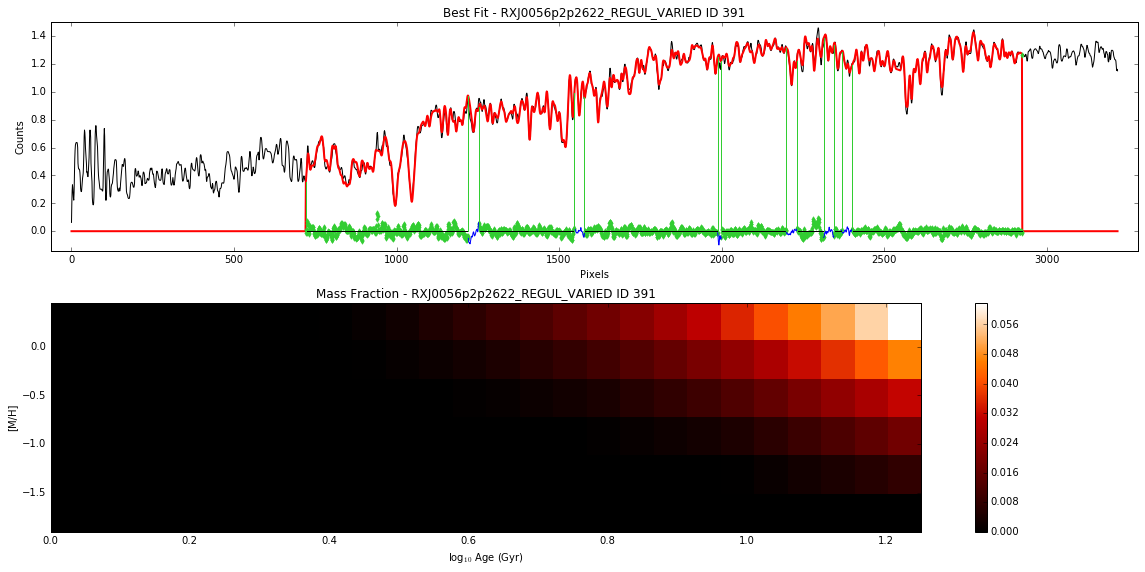

Data written to SFH_data_for_RXJ0056p2p2622_REGUL_VARIED/SFH_data_RXJ0056p2p2622_REGUL_VARIED_ID391.fits
Run complete. Total time taken: 146.023590223 seconds.
Incomplete fits: galaxy IDs []


In [23]:
# Runs pPXF for all galaxies listed in the IDlist in Section 3.
SFH_ppxf(IDlist)

## 6. Repackage output files into a single .fits file:

In [59]:
repackage()

Repackaging all files in \SFH_data_for_RXJ0056p2p2622
66 files repackaged in 179.759476018 seconds.
